<a href="https://colab.research.google.com/github/Nachikaet/River-water-level--LSTM/blob/main/River%20water%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
fileused='/content/drive/MyDrive/ML/finalLSTM.csv'

Mounted at /content/drive


In [ ]:
# Colab-ready: assumes you've mounted drive and set fileused earlier
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# ---- Load data ----
df = pd.read_csv(fileused)
print("Original columns:", df.columns.tolist())
print("Original shape:", df.shape)
print(df.head())

# ---- Make sure date is datetime and set as index (helps time interpolation) ----
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # drop rows with invalid dates
    df = df.dropna(subset=['date'])
    df = df.set_index('date').sort_index()

# ---- Choose the features you want to use ----
features = ['tavg', 'tmin', 'tmax', 'prcp', 'discharge']
# ensure columns exist
missing = [c for c in features if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# ---- Convert to numeric (coerce bad strings to NaN) ----
df[features] = df[features].apply(pd.to_numeric, errors='coerce')

# ---- Check how many NaNs per column before filling ----
print("NaN counts before fill:\n", df[features].isna().sum())

# ---- Fill missing weather values ----
# 1) Interpolate over time (works because index is datetime). If index not datetime, this will be a simple interpolation.
try:
    df[features] = df[features].interpolate(method='time', limit_direction='both')
except Exception:
    df[features] = df[features].interpolate(method='linear', limit_direction='both')

# 2) For remaining gaps (start/end or persistent NaNs), fill with column median
df[features] = df[features].fillna(df[features].median())

# 3) If still any NaNs (unlikely), drop those rows but warn first
nan_after = df[features].isna().sum().sum()
if nan_after > 0:
    print("Warning: some NaNs remain after interpolation/fill. Dropping them.")
    df = df.dropna(subset=features)

print("NaN counts after fill:\n", df[features].isna().sum())

# ---- Quick sanity checks ----
if df.shape[0] < 20:
    raise ValueError("Not enough rows after preprocessing. Need more data.")

# ---- Prepare X and y ----
X = df[features].values  # includes discharge as input
y = df['discharge'].values

# ---- Scale ----
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# ---- Create time sequences ----
timesteps = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled[i:i+timesteps])
    y_seq.append(y_scaled[i+timesteps])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)   # (num_samples, timesteps, num_features)
print("y_seq shape:", y_seq.shape)

# ---- Train/test split (no shuffle for time series) ----
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])

# ---- Build model (safer defaults) ----
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])

# Use a small learning rate and clipnorm to avoid exploding gradients / NaN loss
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

Original columns: ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'discharge']
Original shape: (27685, 12)
         date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun  \
0  1950-01-01 -15.3 -24.8 -12.1   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
1  1950-01-02   NaN -19.1  -7.8   0.8   NaN   NaN   NaN   NaN   NaN   NaN   
2  1950-01-03 -14.1 -14.5  -9.6   1.3   NaN   NaN   NaN   NaN   NaN   NaN   
3  1950-01-04 -16.9 -19.3 -12.4   1.6   NaN   NaN   NaN   NaN   NaN   NaN   
4  1950-01-05   NaN -24.5 -18.2   0.0   NaN   NaN   NaN   NaN   NaN   NaN   

   discharge  
0       36.3  
1       34.2  
2       33.2  
3       32.0  
4       31.5  
NaN counts before fill:
 tavg         2064
tmin           47
tmax           21
prcp           39
discharge     291
dtype: int64
NaN counts after fill:
 tavg         0
tmin         0
tmax         0
prcp         0
discharge    0
dtype: int64
X_seq shape: (27675, 10, 5)
y_seq shape: (27675, 1)
Train s

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0029 - val_loss: 4.0040e-04
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.3203e-04 - val_loss: 3.3152e-04
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.0333e-04 - val_loss: 2.0109e-04
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.3306e-04 - val_loss: 2.5103e-04
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.9170e-04 - val_loss: 1.0490e-04
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.5393e-04 - val_loss: 9.3194e-05
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.3812e-04 - val_loss: 9.5563e-05
Epoch 8/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3714e-04 - val_loss: 8.4957e-05
Epoch 9/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2018e-04 - val_loss: 6.2609e-05
Epoch 10/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.1151e-04 - val_loss: 7.4913e-05
Epoch 11/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.

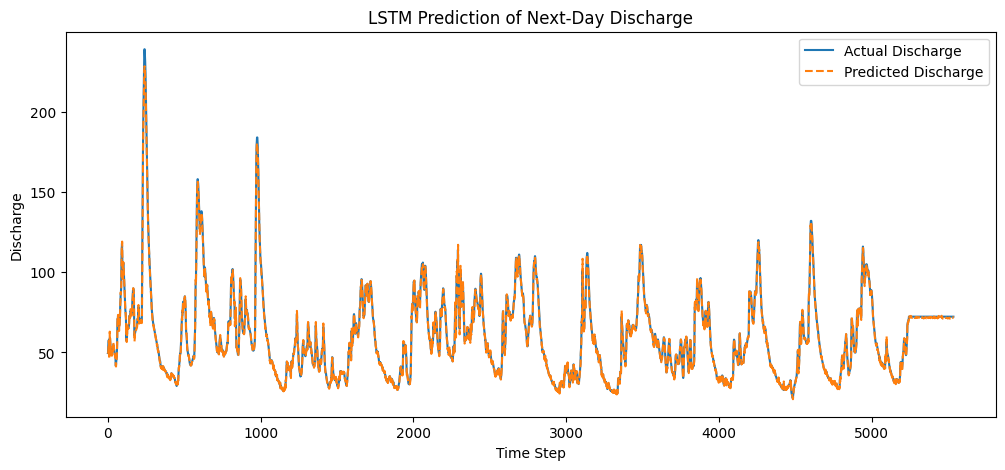

RMSE: 1.5056, MAE: 0.8852


In [ ]:
model.compile(optimizer=optimizer, loss='mse')
model.summary()

# ---- Train ----
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ---- Predict ----
y_pred = model.predict(X_test)

# ---- Inverse scale ----
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# ---- Plot ----
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual Discharge")
plt.plot(y_pred_inv, label="Predicted Discharge", linestyle="dashed")
plt.title("LSTM Prediction of Next-Day Discharge")
plt.xlabel("Time Step")
plt.ylabel("Discharge")
plt.legend()
plt.show()

# ---- Optional metrics ----
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")